In [121]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.signal import correlate, correlation_lags
from scipy.stats import hmean

In [122]:
def input_data(file_1, file_2):
    if file_1.__contains__('.csv'):
        df = pandas.read_csv(file_1)
    else:
        df = pandas.read_excel(file_1, sheet_name='Sheet1')
        
    if file_2.__contains__('.csv'):
        tdf = pandas.read_csv(file_2)
        tobii_left = tdf['left_r']
        tobii_right = tdf['right_r']
        # tobii_mean = tdf['mean']
    else:
        tdf = pandas.read_excel(file_2, index_col=1, sheet_name='Data')
        tdf = tdf.rename(columns={'Pupil diameter left [mm]': 'left_r', 'Pupil diameter right [mm]': 'right_r', 
                                 'Recording timestamp [ms]': 'time'})
        tdf = tdf[['time', 'left_r', 'right_r']].iloc[1:, :]
        # tobii_mean = []
        # for i, c in zip(tobii_left, tobii_right):
        #     tobii_mean.append(np.mean((i, c)))

    return df, tdf

file_1 = '02_19/pupil_data_sun.csv'
file_2 = 'tobii/dark_video_tobii_sun.xlsx'
df, tdf = input_data(file_1, file_2)
video_len = 60+12 #second

# formalise the opencv data (into second)
# df = df[['time', 'left_r', 'right_r']]
s = df['time'][0]
avg_amount = (list(df['time'])[-1] - s)/video_len # calculate interval each second
df['time'] = [ ((i-s)/avg_amount)-4 for i in df['time']]#remove the first 4 seconds, fluctuaion of light in video

df = df[df['time'] >= 0]
df = df.set_index('time')

#formalise eye tracker data (into second)
tdf['time'] = [ (i/1000)-4 for i in tdf['time']] #remove the first 4 seconds, fluctuaion of light in video
tdf['left_r'] = [i/2 for i in tdf['left_r']]
tdf['right_r'] = [i/2 for i in tdf['right_r']]
tdf = tdf[tdf['time'] >= 0]
tdf = tdf.set_index('time')

In [123]:
from collections import OrderedDict
def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def eliminate_outliers(values, bias = 0.5):
    print('before', len(values))
    q1,q3 = get_quartiles(values)
    iqr = q3 - q1
    lowerLimit = q1 - bias*iqr
    upperLimit = q3 + bias*iqr
    print('lower', lowerLimit, q1, q3, 'upper', upperLimit)
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: result.append(np.nan)
        else:
            result.append(v)
    print('after', len([i for i in result if i is not np.nan]), '\n')
    return result

before 3984
lower 16.925 17.5 29.0 upper 29.575
after 2370 

total valid radius 652


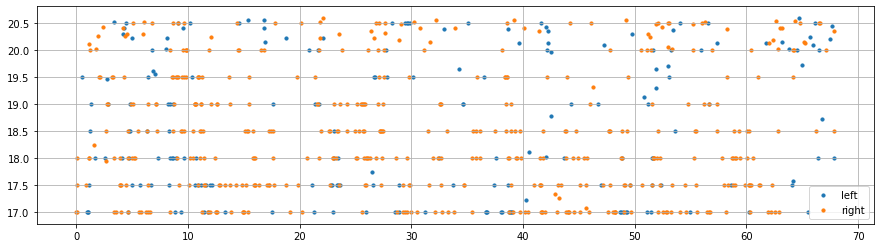

In [124]:
#remove by radius
baseline = 17
values = np.concatenate( [list(df['left_r']), list(df['right_r'])] )
sep = len(df['left_r'])

values = eliminate_outliers(values, 0.05)
df['left_r'] = values[:sep]
df['right_r'] = values[sep:]

# #remove by x coordinate
# values = np.concatenate( [list(df['left_x']), list(df['right_x'])] )
# sep = len(df['left_x'])

# values = eliminate_outliers(values)
# df['left_x'] = values[:sep]
# df['right_x'] = values[sep:]

left_r = []
right_r = []
for i, r in df.iterrows():
    if abs(r['left_r'] - baseline) > 3.6:
        left_r.append(np.nan)
    else:
        left_r.append(r['left_r'])
        
    if abs(r['right_r'] - baseline) > 3.6:
        right_r.append(np.nan)
    else:
        right_r.append(r['right_r'])
        
df['left_r'] = left_r
df['right_r'] = right_r

#plot left and right
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(x=list(df.index), y=df['left_r'], s=10, label='left')
ax.scatter(x=list(df.index), y=df['right_r'], s=10, label='right')
ax.grid()
ax.legend(loc='best')

print('total valid radius', len([i for i in left_r if not np.isnan(i)]) + len([i for i in right_r if not np.isnan(i)]))

## scatter plot of radius of eye_tracker

before 8296
lower 0.9775 0.985 1.06 upper 1.0675000000000001
after 5184 

total valid radius 4456


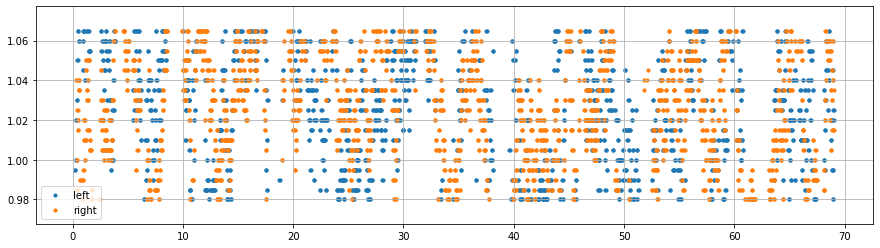

In [125]:
t_baseline = 0.98
values = np.concatenate( [list(tdf['left_r']), list(tdf['right_r'])] )
sep = len(tdf['left_r'])

values = eliminate_outliers(values, 0.1)
tdf['left_r'] = values[:sep]
tdf['right_r'] = values[sep:]

left_r = []
right_r = []
for i, r in tdf.iterrows():
    if abs(r['left_r'] - t_baseline) > 0.2:
        left_r.append(np.nan)
    else:
        left_r.append(r['left_r'])
        
    if abs(r['right_r'] - t_baseline) > 0.2:
        right_r.append(np.nan)
    else:
        right_r.append(r['right_r'])
        
tdf['left_r'] = left_r
tdf['right_r'] = right_r

#plot left and right
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(x=list(tdf.index), y=tdf['left_r'], s=10, label='left')
ax.scatter(x=list(tdf.index), y=tdf['right_r'], s=10, label='right')
ax.grid()
ax.legend(loc='best')
print('total valid radius', len([i for i in left_r if not np.isnan(i)]) + len([i for i in right_r if not np.isnan(i)]))

In [126]:
#merge left and right
def merge_both_side(df):
    result = []
    for i, r in df.iterrows():
        a = r['left_r']
        b = r['right_r']

        if not np.isnan(a) and not np.isnan(b):
            result.append(hmean((a, b)))
        elif not np.isnan(a):
            result.append(a)
        elif not np.isnan(b):
            result.append(b)
        else:
            result.append(np.nan)
    df['pupil'] = result
    df = df.drop(labels=['left_r', 'right_r'], axis=1)
    return df

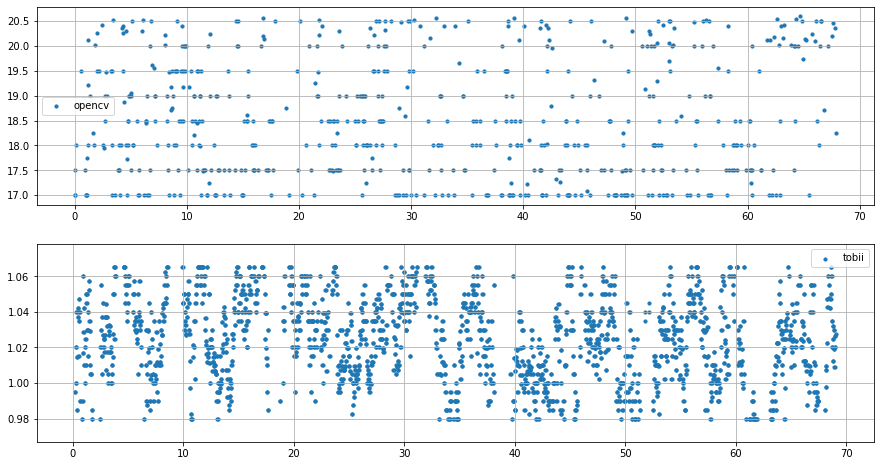

In [127]:
merge_df = merge_both_side(df)
merge_tdf = merge_both_side(tdf)

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))

ax1.scatter(x=list(merge_df.index), y=merge_df['pupil'], s=10, label='opencv')
ax2.scatter(x=list(merge_tdf.index), y=merge_tdf['pupil'], s=10, label='tobii')

ax1.grid()
ax1.legend(loc='best')
ax2.grid()
ax2.legend(loc='best')

In [128]:
def normalise(df):
    result = {}
    values = []
    current_sec = 0
    for i, r in df.iterrows():
        if i <= current_sec:
            if r['pupil'] != 0 and not np.isnan(r['pupil']):
                values.append(r['pupil'])
        else:
            if len(values) == 0:
                if current_sec > 0:
                    result.update({current_sec: result[current_sec-1]}) #if no available value, then select the last one
                else:
                    result.update({current_sec: np.nan})
            else:
                values = sorted(values)
                if len(values) >= 4:
                    values = values[1:-2] #remove the biggest and smallest
                result.update({current_sec: hmean(values)})
                values = []
                
            current_sec += 0.5
            if r['pupil'] != 0 and not np.isnan(r['pupil']):
                values.append(r['pupil'])
    
    #for the last sec
    values = sorted(values)
    if len(values) >= 4:
        values = values[1:-2] #remove the biggest and smallest
    result.update({current_sec: hmean(values)})

    return result

In [129]:
def cal_rate(ary, baseline=None): #pupil change rate
    result = []
    if baseline is None:
        for a, b in zip(ary[:-2], ary[1:]):
            result.append( (b-a)/a )
    else:
        for a in ary:
            result.append( (a-baseline)/baseline)
    return result

def plot_rate(ary1, ary2, timeframe, overlap):
    ### plot
    total = 0 #total matching
    for i in range(min(len(ary2), len(ary1))-1):
        if ary1[i] >= ary1[i+1] and ary2[i] >= ary2[i+1]: total += 1
        elif ary1[i] <= ary1[i+1] and ary2[i] <= ary2[i+1]: total += 1

    print('total matching ', total, len(ary1)-1, len(ary2)-1, total/(len(ary1)-1), total/(len(ary2)-1))

    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))
    ax1.plot(ary1, label='eye_tracker')
    ax1.plot(ary2, label='opencv software')

    ax1.scatter(x=np.arange(len(ary1)), y=ary1, s=10, color='red')
    ax1.scatter(x=np.arange(len(ary2)), y=ary2, s=10, color='red')

    ax1.set_xlabel('time(per '+ str(timeframe) +' second)')
    ax1.set_ylabel('percentage changes in pupil size')
    ax1.grid()
    ax1.legend(loc='best')
    
    corr = correlate(ary1, ary2)
    lags = correlation_lags(len(ary1), len(ary2))
    corr /= np.max(corr)
    ax2.plot(lags, corr, label='cross-correlated signals')
    ax2.grid()
    ax1.set_title('percentage changes in pupil size line charts (' + str(timeframe) + 'sec timeframe with ' + str(overlap) + ')')
    ax2.set_title('cross-correlation lag')
    print('The cross-correlation score is: ', sum(corr))
    
    import scipy.stats as stats       
    r, p = stats.pearsonr(np.arange(len(ary1)), ary1)
    print('pearson correlation of eye_tracker (r, p):', r, p)

    r, p = stats.pearsonr(np.arange(len(ary2)), ary2)
    print('pearson correlation of opencv software (r, p):', r, p)
    
    plt.tight_layout()
    plt.savefig('02_19/sun_' + str(timeframe) + '_plot_baseline.png', dpi=300)

In [130]:
def normalise_sec(df, sec=2, overlap=1, half=False): #input dict, half: if overlap has 0.5 sec
    result = {}
    end = int(list(df.keys())[-1])-sec-overlap       
    interval = sec-overlap
    if half:
        interval = sec
        end -= 0.5
        end = int(end)
    
    current = 0
    values = []
    while (current <= end):
        # get the value for each 0.5 second
        seconds = np.arange(current, current+sec, 0.5)
        for a in seconds:
            if a <= list(df.keys())[-1]:
                n = df[a]
                if not np.isnan(n):
                    values.append(n)
                
        # update result
        if len(values) == 0:
            result.update({current: result[i-1]})
        else:
            result.update({current: hmean(values)})
            values = []
            
        current += sec
        current -= overlap
                
    return result

In [131]:
def normalise_rate_sec(ary, sec=2, overlap=1, half=False): #input dict, half: if overlap has 0.5 sec
    result = []
    end = len(ary)-sec-overlap       
    interval = sec-overlap
    if half:
        interval = sec
        end -= 0.5
        end = int(end)
    
    current = 0
    values = []
    while (current <= end):
        # get the value for each 1 second
        seconds = np.arange(current, current+sec, 1)
        for a in seconds:
            if a <= len(ary):
                n = ary[a]
                if not np.isnan(n):
                    values.append(n)
                
        # update result
#         print(values)
        if len(values) == 0:
            result.append(result[i-1])
        else:
            result.append(np.mean(values))
            values = []
            
        current += sec
        current -= overlap
                
    return result

In [132]:
opencv = normalise(merge_df)
tobii = normalise(merge_tdf)

## 1 second timeframe

[CHECK] df total  68  values for  67  second
[CHECK] tdf total  70  values for  69  second
total matching  31 69 67 0.4492753623188406 0.4626865671641791
The cross-correlation score is:  66.61702543144065
pearson correlation of eye_tracker (r, p): -0.2799378965495101 0.01892047363201624
pearson correlation of opencv software (r, p): 0.149500512817072 0.22367696147599975


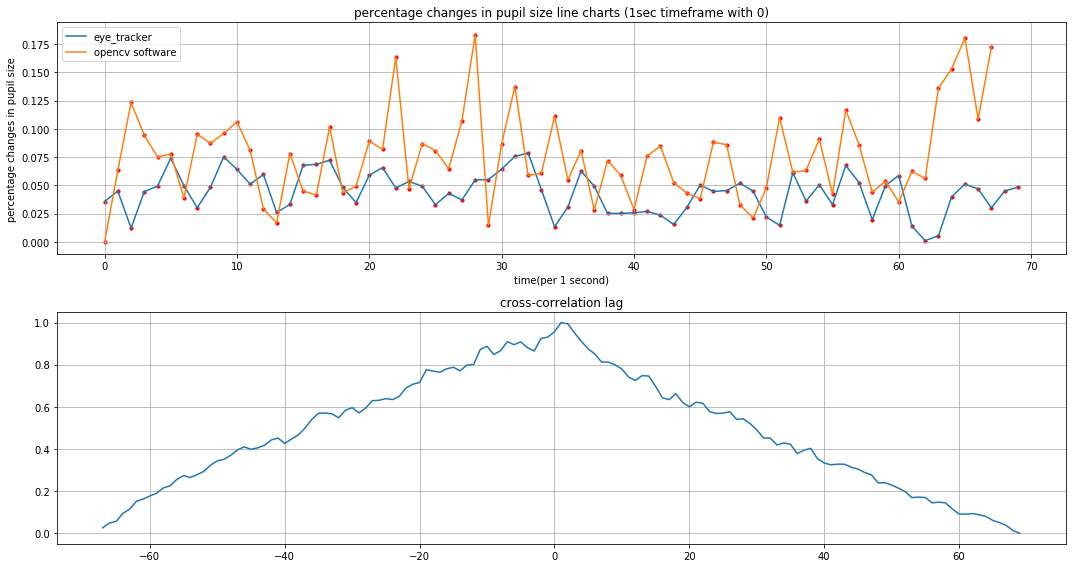

In [133]:
#normalise into 1 second timeframe
timeframe = 1
overlap = 0
df_1 = normalise_sec(opencv, timeframe, overlap)
tdf_1 = normalise_sec(tobii, timeframe, overlap)
print('[CHECK] df total ', len(df_1.keys()), ' values for ', list(df_1.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_1.keys()), ' values for ', list(tdf_1.keys())[-1], ' second')
py_rate_1 = cal_rate(list(df_1.values()), baseline)
tb_rate_1 = cal_rate(list(tdf_1.values()), t_baseline)
plot_rate(tb_rate_1, py_rate_1, timeframe, overlap)

total matching  33 67 65 0.4925373134328358 0.5076923076923077
The cross-correlation score is:  62.36612874155338
pearson correlation of eye_tracker (r, p): -0.3653048994233708 0.002190218132826291
pearson correlation of opencv software (r, p): 0.2738576892828869 0.026078152726992453


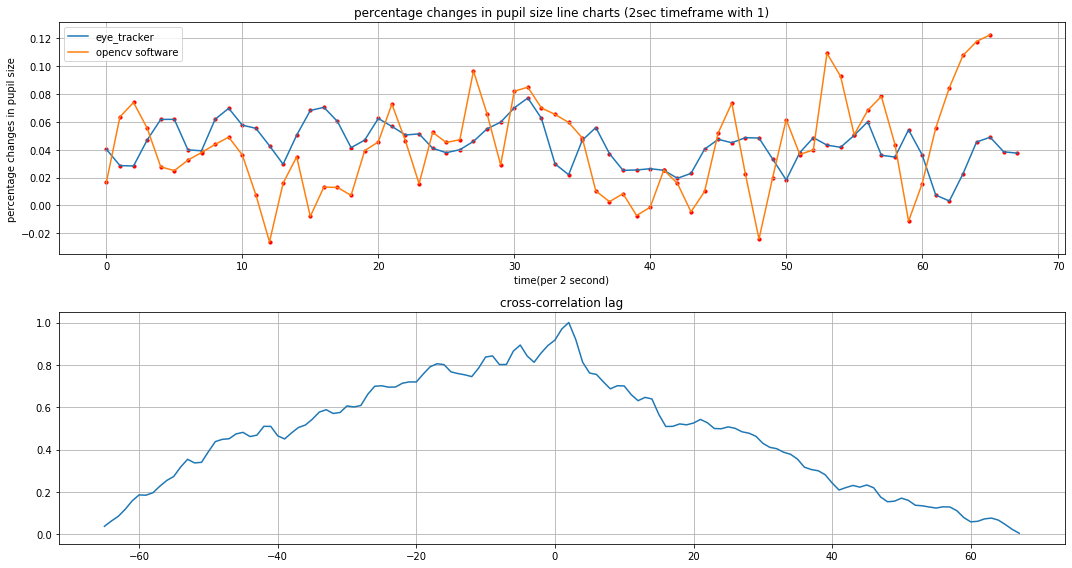

In [102]:
#normalise into 2 second timeframe
timeframe = 2
overlap = 1
py_rate_2 = normalise_rate_sec(py_rate_1, timeframe, overlap)
tb_rate_2 = normalise_rate_sec(tb_rate_1, timeframe, overlap)
plot_rate(tb_rate_2, py_rate_2, timeframe, overlap)

total matching  13 20 19 0.65 0.6842105263157895
The cross-correlation score is:  -1.4949297633664553
pearson correlation of eye_tracker (r, p): -0.1573050366242401 0.49588385571158944
pearson correlation of opencv software (r, p): 0.16051068794423393 0.49903475310739387


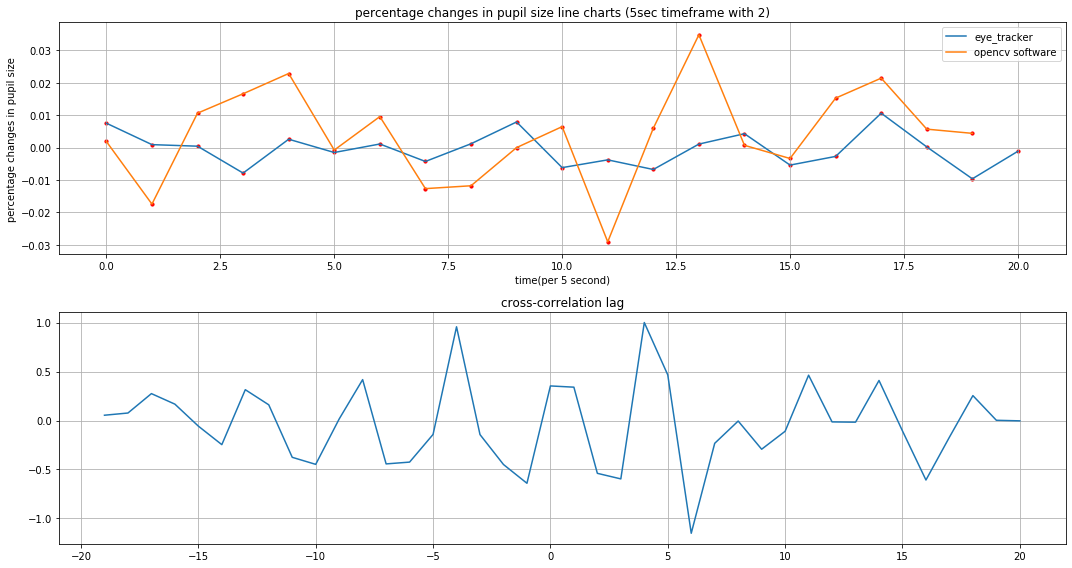

In [39]:
#normalise into 2 second timeframe
timeframe = 5
overlap = 2
py_rate_3 = normalise_rate_sec(py_rate_1, timeframe, overlap)
tb_rate_3 = normalise_rate_sec(tb_rate_1, timeframe, overlap)
plot_rate(tb_rate_3, py_rate_3, timeframe, overlap)

## 2 second timeframe (1sec overlap)

[CHECK] df total  66  values for  65  second
[CHECK] tdf total  68  values for  67  second
total matching  30 67 65 0.44776119402985076 0.46153846153846156
The cross-correlation score is:  65.32648976436651
pearson correlation of eye_tracker (r, p): -0.368171141323403 0.002008217509918638
pearson correlation of opencv software (r, p): 0.07047572916315889 0.5739061850773


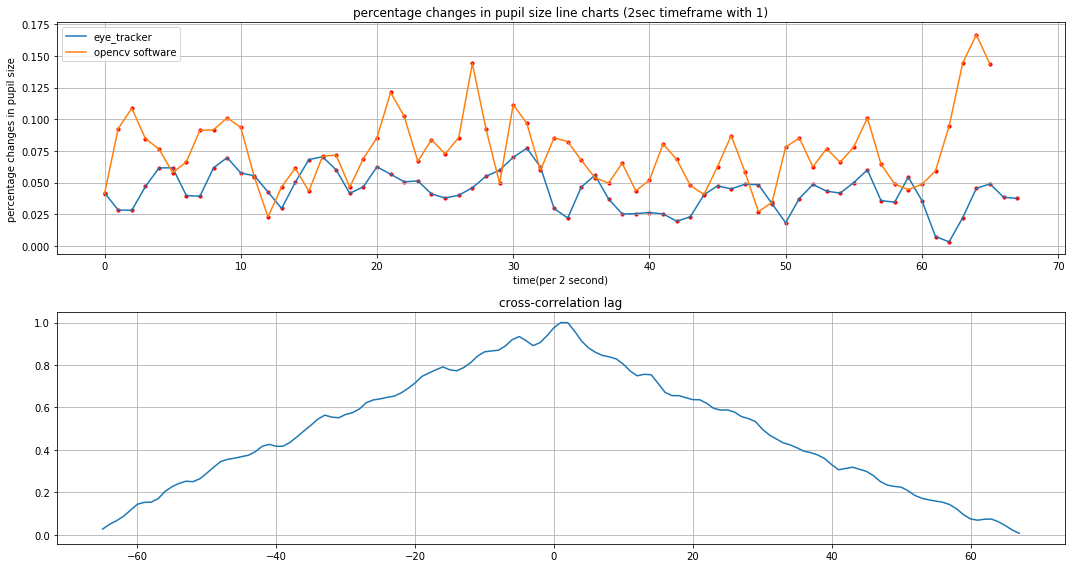

In [134]:
#normalise into 2 second timeframe
timeframe = 2
overlap = 1
df_2 = normalise_sec(opencv, timeframe, overlap)
tdf_2 = normalise_sec(tobii, timeframe, overlap)
print('[CHECK] df total ', len(df_2.keys()), ' values for ', list(df_2.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_2.keys()), ' values for ', list(tdf_2.keys())[-1], ' second')
py_rate_2 = cal_rate(list(df_2.values()), baseline)
tb_rate_2 = cal_rate(list(tdf_2.values()), t_baseline)
plot_rate(tb_rate_2, py_rate_2, timeframe, overlap)

## 3 second timeframe (1.5sec overlap)

[CHECK] df total  43  values for  63.0  second
[CHECK] tdf total  44  values for  64.5  second
total matching  22 43 42 0.5116279069767442 0.5238095238095238
The cross-correlation score is:  42.31052114419574
pearson correlation of eye_tracker (r, p): -0.42504930047282846 0.004026705862204602
pearson correlation of opencv software (r, p): -0.013132967869343759 0.9333867982688037


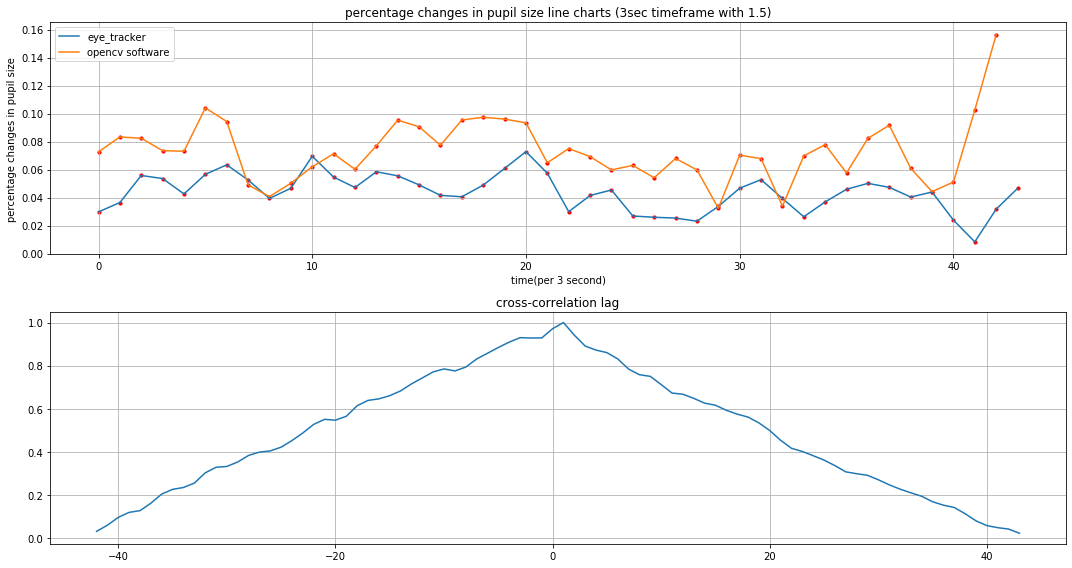

In [143]:
#normalise into 3 second timeframe
timeframe = 3
overlap = 1.5
df_3 = normalise_sec(opencv, timeframe, overlap, True)
tdf_3 = normalise_sec(tobii, timeframe, overlap, True)
print('[CHECK] df total ', len(df_3.keys()), ' values for ', list(df_3.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_3.keys()), ' values for ', list(tdf_3.keys())[-1], ' second')
py_rate_3 = cal_rate(list(df_3.values()), baseline)
tb_rate_3 = cal_rate(list(tdf_3.values()), t_baseline)
plot_rate(tb_rate_3, py_rate_3, timeframe, overlap)

## 5 second timeframe (1.5sec overlap)

[CHECK] df total  18  values for  59.5  second
[CHECK] tdf total  19  values for  63.0  second
total matching  9 17 17 0.5294117647058824 0.5294117647058824
The cross-correlation score is:  17.79759970051695
pearson correlation of eye_tracker (r, p): -0.5590171183423939 0.01587568855688524
pearson correlation of opencv software (r, p): -0.23915791894588406 0.33918008810970696


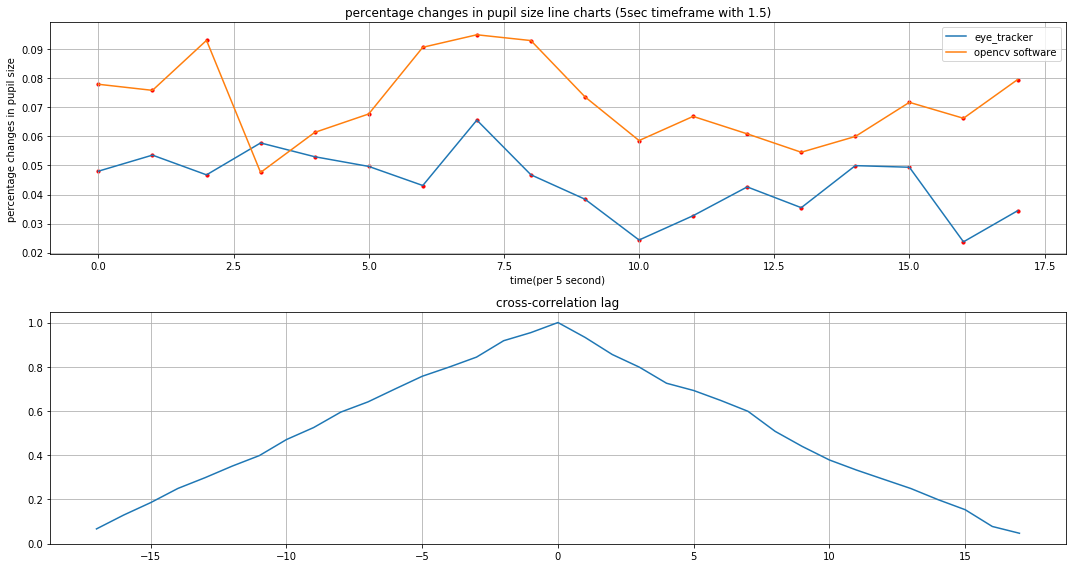

In [141]:
timeframe = 5
overlap = 1.5
df_5 = normalise_sec(opencv, timeframe, overlap, True)
tdf_5 = normalise_sec(tobii, timeframe, overlap, True)
print('[CHECK] df total ', len(df_5.keys()), ' values for ', list(df_5.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_5.keys()), ' values for ', list(tdf_5.keys())[-1], ' second')
py_rate_5 = cal_rate(list(df_5.values()), baseline)
tb_rate_5 = cal_rate(list(tdf_5.values()), t_baseline)[1:]
plot_rate(tb_rate_5, py_rate_5, timeframe, overlap)

## 8 second timeframe (2sec overlap)

[CHECK] df total  10  values for  54  second
[CHECK] tdf total  11  values for  60  second
total matching  4 10 9 0.4 0.4444444444444444
The cross-correlation score is:  10.541660447220556
pearson correlation of eye_tracker (r, p): -0.6379692839762042 0.03468306799329405
pearson correlation of opencv software (r, p): -0.2794957279498045 0.4341671575986312


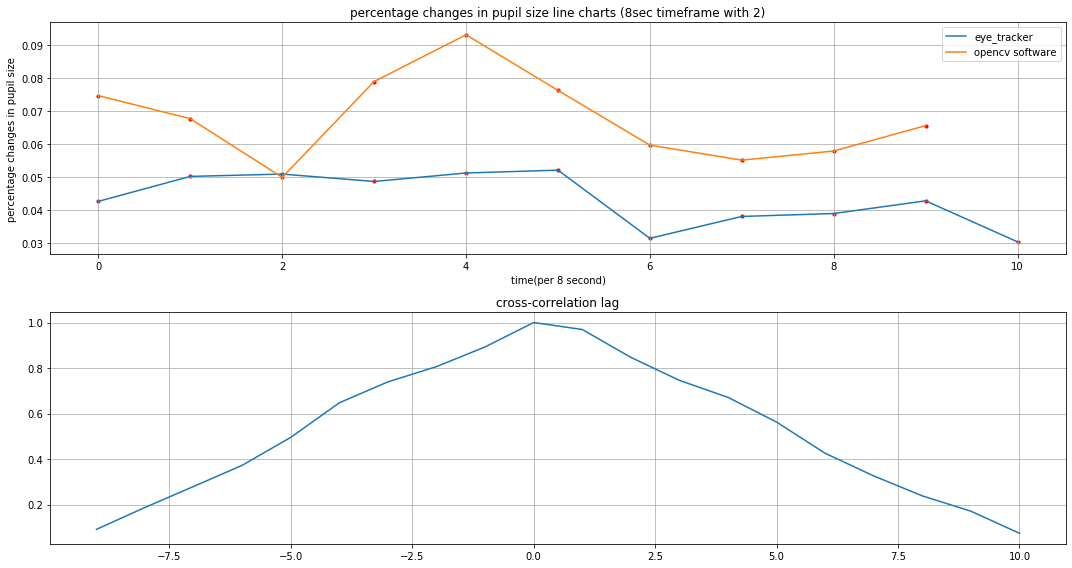

In [138]:
timeframe = 8
overlap = 2
df_8 = normalise_sec(opencv, timeframe, overlap)
tdf_8 = normalise_sec(tobii, timeframe, overlap)
print('[CHECK] df total ', len(df_8.keys()), ' values for ', list(df_8.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_8.keys()), ' values for ', list(tdf_8.keys())[-1], ' second')
py_rate_8 = cal_rate(list(df_8.values()), baseline)
tb_rate_8 = cal_rate(list(tdf_8.values()), t_baseline)
plot_rate(tb_rate_8, py_rate_8, timeframe, overlap)

## dtw

In [139]:
from dtw import dtw, accelerated_dtw
def cal_dtw(tobii, opencv, timeframe):
    d1 = [(k, i) for k, i in enumerate(tobii)]
    d2 = [(k, i) for k, i in enumerate(opencv)]

    distance, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1, d2, dist='euclidean')

    plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    plt.plot(path[0], path[1], 'w')
    plt.xlabel('tobii')
    plt.ylabel('opencv')
    plt.title(f'DTW Minimum Path with minimum distance: {np.round(distance,2)}')
    plt.tight_layout()
    plt.savefig('02_19/light_' + str(timeframe) + '_dtw_baseline.png', dpi=300)
    plt.show()

1 SEC


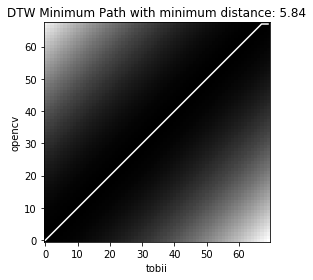

2 SEC


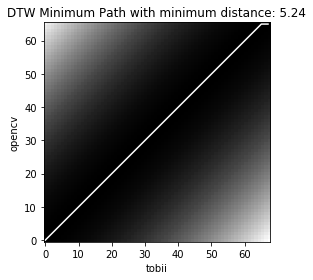

3 SEC


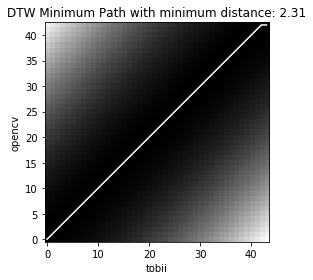

5 SEC


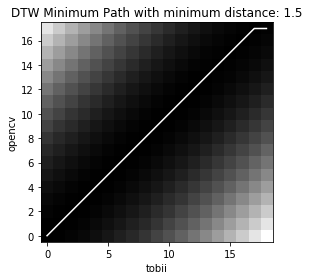

8 SEC


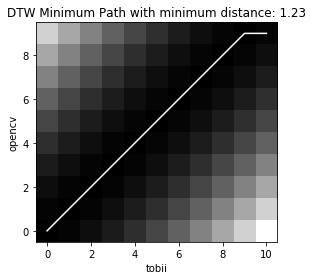

In [140]:
print('1 SEC')
cal_dtw(tb_rate_1, py_rate_1, 1)
print('2 SEC')
cal_dtw(tb_rate_2, py_rate_2, 2)
print('3 SEC')
cal_dtw(tb_rate_3, py_rate_3, 3)
print('5 SEC')
cal_dtw(tb_rate_5, py_rate_5, 5)
print('8 SEC')
cal_dtw(tb_rate_8, py_rate_8, 8)